# This notebook will contain the model training process, evaluation, and hyperparameter tuning:

- Splitting data into train/test sets

- Define our customized objective function for model selection

- Model selection using H2O AutoML, LightGBM + HyperOpt combining with SMOTE and GAN

- Hyperparameter tuning

- Compare Revenues in each model

- SHAP analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import label_binarize
import h2o
from h2o.automl import H2OAutoML
from collections import defaultdict
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample

### Input 02-notebook file

In [29]:
path = '../data/processed/heart_2022_processed_02.csv'

In [30]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

State  Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
414543    PR    1              2            0.100305         -0.515761   
358772    VA    0              3           -0.489368         -0.515761   
51520     CT    0              0           -0.489368         -0.515761   
207989    MT    0              3           -0.371433         -0.515761   
256505    NY    1              3            0.336175          2.528260   

        LastCheckupTime  PhysicalActivities  SleepHours  RemovedTeeth  \
414543                3                   1   -0.700087             0   
358772                2                   1   -0.018124             0   
51520                 3                   1    0.663840             1   
207989                3                   1   -0.700087             1   
256505                3                   1   -1.382051             0   

        HadHeartAttack  ...  HeightInMeters^2_poly  \
414543               0  ...              -0.052729   
358772               0  ...               0.230557   
51520                0  ...              -0.694458   
207989               0  ...              -0.961225   
256505               0  ...              -1.223037   

        HeightInMeters_PhysicalHealthDays_poly  \
414543                                0.102783   
358772                               -0.488300   
51520                                -0.488300   
207989                               -0.377037   
256505                                0.275935   

        HeightInMeters_MentalHealthDays_poly  HeightInMeters_SleepHours_poly  \
414543                             -0.514716                       -0.679104   
358772                             -0.514716                        0.058332   
51520                              -0.514716                        0.417398   
207989                             -0.514716                       -0.910759   
256505                              2.302687                       -1.586420   

        PhysicalHealthDays^2_poly  PhysicalHealthDays_MentalHealthDays_poly  \
414543                  -0.265903                                 -0.264944   
358772                  -0.369584                                 -0.264944   
51520                   -0.369584                                 -0.264944   
207989                  -0.365437                                 -0.264944   
256505                  -0.166370                                  0.959922   

        PhysicalHealthDays_SleepHours_poly  MentalHealthDays^2_poly  \
414543                            0.024753                -0.377532   
358772                           -0.466040                -0.377532   
51520                            -0.466040                -0.377532   
207989                           -0.367881                -0.377532   
256505                            0.106552                 2.385668   

        MentalHealthDays_SleepHours_poly  SleepHours^2_poly  
414543                         -0.496965          -0.674034  
358772                         -0.496965          -0.109551  
51520                          -0.496965           0.541774  
207989                         -0.496965          -0.674034  
256505                          1.702569          -1.151672  

[5 rows x 78 columns]

In [31]:
output_path = '../data/cleaned/dtype.csv'
df.dtypes.to_csv(output_path)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416184 entries, 0 to 416183
Data columns (total 78 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   State                                             416184 non-null  object 
 1   Sex                                               416184 non-null  int64  
 2   GeneralHealth                                     416184 non-null  int64  
 3   PhysicalHealthDays                                416184 non-null  float64
 4   MentalHealthDays                                  416184 non-null  float64
 5   LastCheckupTime                                   416184 non-null  int64  
 6   PhysicalActivities                                416184 non-null  int64  
 7   SleepHours                                        416184 non-null  float64
 8   RemovedTeeth                                      416184 non-null  int64  
 9   HadH

### H2O AutoML to Select and Train the Best Mode

#### Splitting data into train/test sets


In [33]:
# Start H2O cluster
h2o.init()
# Convert data into H2O frame (required by H2O)
h2o_df = h2o.H2OFrame(df)
h2o_df['HadHeartAttack'] = h2o_df['HadHeartAttack'].asfactor()

# Specify the target column
target = 'HadHeartAttack'

# Define the feature columns
features = [col for col in df.columns if col != target]

# Split the dataset into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)
h2o.export_file(train, path="../data/processed/train_data_03.csv", force=True)
h2o.export_file(test, path="../data/processed/test_data_03.csv", force=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp28xuqduf
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp28xuqduf/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp28xuqduf/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Taipei
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    2 months and 2 days
H2O_cluster_name:           H2O_from_python_chiushihchan_tisgl0
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.13.3 final
--------------------------  -----------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


#### Obective function

For each sample:

- If the model predicts negative (0):

    - If actual is 0 (TN) → revenue = 271,139

    - If actual is 1 (FN) → revenue = –401,832

- If the model predicts positive (1): 

    - It’s excluded from the revenue calculation (just skip it)

The Revenue Function Implied Weight Ratio
Given:
``` python
TN reward: +271,139
FN cost: -401,832
```

We want the model to learn that FN is ~1.48× worse than TN is good:

``` python
class_0_weight = 271139
class_1_weight = 401832  # higher penalty for misclassifying positives
```
To keep this relative but normalized, you can rescale:

``` python
total = class_0_weight + class_1_weight
sampling_factors = [
    class_1_weight / total,  # class 0
    class_0_weight / total   # class 1
]
```

Which becomes:

``` python
sampling_factors = [0.5976, 0.4024]  # class 0, class 1
```

But to invert this for class weighting (more weight to costly mistakes), we assign higher weight to class 1:

``` python
sampling_factors = [0.4, 0.6]
```
This is more intuitive for H2OAutoML(balance_classes=True).

In [34]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, balance_classes=True,
    class_sampling_factors=[0.4, 0.6],  # class 0, class 1
    sort_metric="AUTO"
)
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |
17:57:05.668: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20250529_175705


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  --------
Stacking strategy                          blending
Number of base models (used / total)       5/5
# GBM base models (used / total)           1/1
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           2/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         AUTO
Metalearner nfolds                         0
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.036945134094296506
RMSE: 0.192211170576261
LogLoss: 0.13380165625699475
AUC: 0.9145192859187082
AUCPR: 0.4676539137892983
Gini: 0.8290385718374165
Null degrees of freedom: 9992
Residual degrees of freedom: 9987
Null deviance: 4214.512958889473
Residual deviance: 2674.1599019522973
AIC: 2686.1599019522973

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3009227965154455
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      9217  234  0.0248   (234.0/9451.0)
1      285   257  0.5258   (285.0/542.0)
Total  9502  491  0.0519   (519.0/9993.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300923     0.49758   147
max f2                       0.110355     0.581642  237
max f0point5                 0.383053     0.532474  119
max accuracy                 0.467944     0.952267  90
max precision                0.836324     1         0
max recall                   0.00273768   1         394
max specificity              0.836324     1         0
max absolute_mcc             0.312365     0.471029  143
max min_per_class_accuracy   0.0596888    0.835256  286
max mean_per_class_accuracy  0.0518716    0.837611  296
max tns                      0.836324     9451      0
max fns                      0.836324     541       0
max fps                      0.000832723  9451      399
max tps                      0.00273768   542       394
max tnr                      0.836324     1         0
max fnr                      0.836324     0.998155  0
max fpr                      0.000832723  1         399
max tpr                      0.00273768   1         394

Gains/Lift Table: Avg response rate:  5.42 %, avg score:  5.58 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010007                    0.59072            12.7217    12.7217            0.69             0.680769    0.69                        0.680769            0.127306        0.127306                   1172.17   1172.17            0.124026
2        0.020014                    0.516014           10.6936    11.7077            0.58             0.552095    0.635                       0.616432            0.107011        0.234317                   969.362   1070.77            0.226593
3        0.030021                    0.438202           9.77175    11.0624            0.53             0.476808    0.6                         0.569891            0.097786        0.332103                   877.175   1006.24            0.319406
4        0.040028                    0.37717            8.66552    10.4632     

In [35]:
#  Define custom revenue function
def total_revenue(y_true, y_pred):
    return sum(
        271_139 if (yp == 0 and yt == 0) else
       -401_832 if (yp == 0 and yt == 1) else
        0
        for yt, yp in zip(y_true, y_pred)
    )

In [36]:
def optimize_revenue_threshold(y_true, y_probs, thresholds=np.linspace(0, 1, 100)):
    best_threshold = 0.5
    best_revenue = float('-inf')

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        revenue = total_revenue(y_true, y_pred)
        if revenue > best_revenue:
            best_revenue = revenue
            best_threshold = t

    return best_threshold, best_revenue

In [37]:
leaderboard = aml.leaderboard.as_data_frame()
model_ids = leaderboard['model_id'].tolist()[:10]  # top-10 models

validation_revenue_records = []

for model_id in model_ids:
    model = h2o.get_model(model_id)
    preds = model.predict(train)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = train[target].as_data_frame().values.flatten()

    threshold, revenue = optimize_revenue_threshold(y_true, y_probs)

    validation_revenue_records.append({
        "model_id": model_id,
        "threshold": threshold,
        "validation_revenue": revenue
    })

stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [38]:
test_results = []

for record in validation_revenue_records:
    model = h2o.get_model(record["model_id"])
    threshold = record["threshold"]
    
    preds = model.predict(test)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = test[target].as_data_frame().values.flatten()
    y_pred = (y_probs >= threshold).astype(int)

    revenue = total_revenue(y_true, y_pred)

    test_results.append({
        "model_id": record["model_id"],
        "threshold": threshold,
        "test_revenue": revenue,
        "validation_revenue": record["validation_revenue"]
    })

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
glm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [23]:
# Baseline: always predict negative
y_true_baseline = test[target].as_data_frame().values.flatten()
baseline_revenue = sum(
    271_139 if y == 0 else -401_832 for y in y_true_baseline
)

print(f"📉 Baseline (no model) revenue on test set: {baseline_revenue:,}")

NameError: name 'test' is not defined

In [40]:
results_df = pd.DataFrame(test_results)
results_df = results_df.sort_values(by="test_revenue", ascending=False)

results_df["gain_vs_baseline"] = results_df["test_revenue"] - baseline_revenue

print("Top revenue models on test set:")
results_df

Top revenue models on test set:


model_id  threshold  test_revenue  \
5  StackedEnsemble_AllModels_4_AutoML_1_20250529_...   0.414141   19665034487   
3  StackedEnsemble_AllModels_3_AutoML_1_20250529_...   0.414141   19662564977   
1  StackedEnsemble_AllModels_2_AutoML_1_20250529_...   0.404040   19654620018   
2  StackedEnsemble_BestOfFamily_3_AutoML_1_202505...   0.404040   19654077740   
6  StackedEnsemble_BestOfFamily_2_AutoML_1_202505...   0.393939   19654013373   
7  StackedEnsemble_BestOfFamily_1_AutoML_1_202505...   0.404040   19653192148   
9       GBM_grid_1_AutoML_1_20250529_175705_model_47   0.383838   19652318268   
4  StackedEnsemble_AllModels_1_AutoML_1_20250529_...   0.393939   19651461935   
0  StackedEnsemble_BestOfFamily_4_AutoML_1_202505...   0.363636   19651157647   
8                     GLM_1_AutoML_1_20250529_175705   0.383838   19637750882   

   validation_revenue  gain_vs_baseline  
5         79321221706         238163575  
3         79361336635         235694065  
1         79374692676         227749106  
2         79270466044         227206828  
6         79287701918         227142461  
7         78971031002         226321236  
9         78935312857         225447356  
4         79367463618         224591023  
0         79163073591         224286735  
8         78754913699         210879970

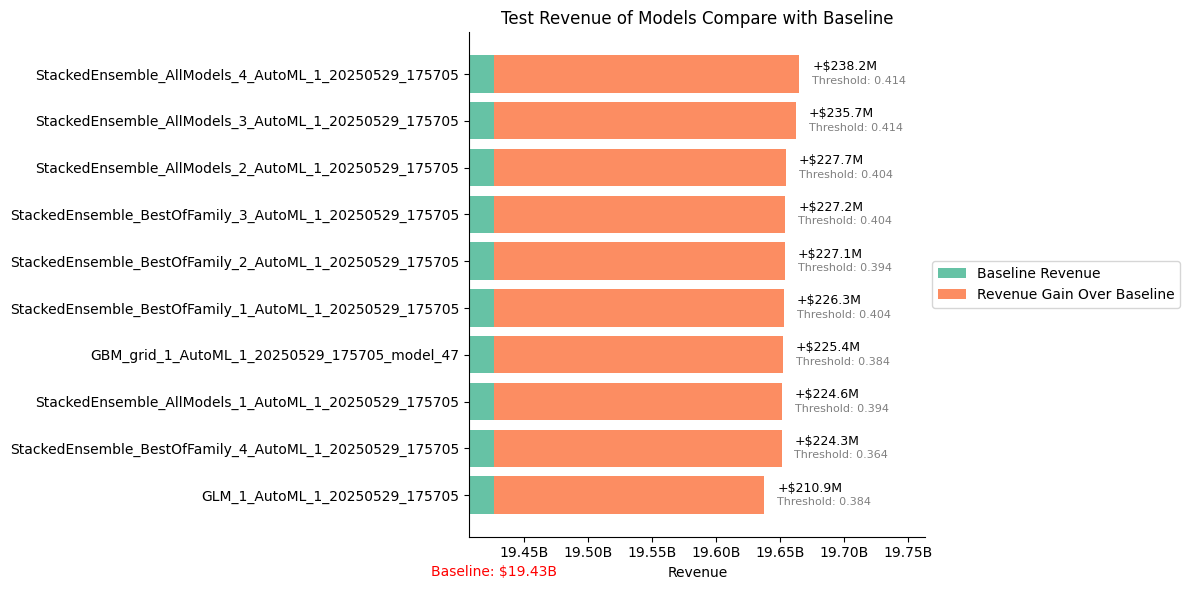

In [43]:
sorted_filtered_df = results_df.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)
sorted_filtered_df.to_csv("../data/processed/test_leaderboard_03.csv")

palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in sorted_filtered_df.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain Over Baseline" if i == 0 else "")
    
    # Annotate gain
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    
    # Annotate threshold
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

# Axis formatting
ax.set_yticks(range(len(sorted_filtered_df)))
ax.set_yticklabels(sorted_filtered_df["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compare with Baseline")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_filtered_df["test_revenue"].max() * 1.005)

# Move baseline annotation slightly downward to avoid overlap
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')

# Clean up the plot
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


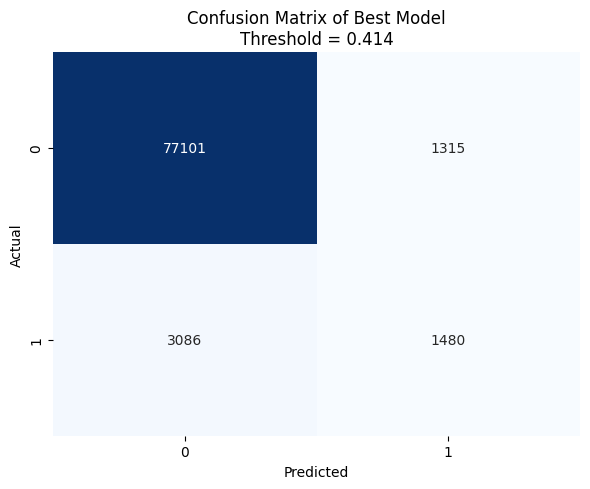

In [44]:
# Assume best model is the top one in results_df
best_model_id = results_df.sort_values(by="test_revenue", ascending=False).iloc[0]["model_id"]
best_threshold = results_df.sort_values(by="test_revenue", ascending=False).iloc[0]["threshold"]

# Retrieve the best model from H2O
best_model = h2o.get_model(best_model_id)

# Get predictions
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix of Best Model\nThreshold = {best_threshold:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

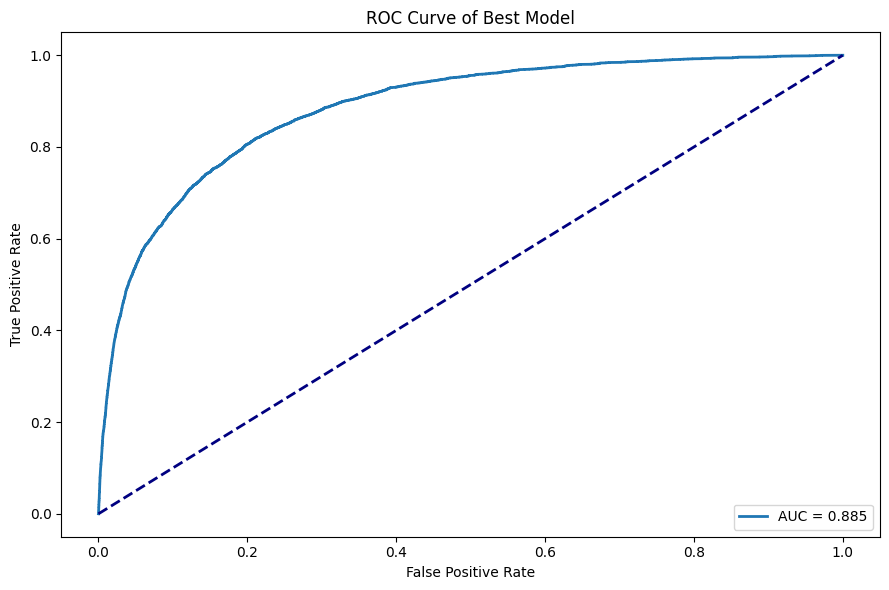

In [45]:
# AUC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve of Best Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [46]:
best_model = h2o.get_model(best_model_id)
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Compute metrics
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_probs)
}

# Format as DataFrame
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
metrics_df.reset_index(inplace=True)
metrics_df.columns = ["Metric", "Value"]

print("Metrics of Best Model")
metrics_df

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Metrics of Best Model


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Metric     Value
0   Accuracy  0.946964
1  Precision  0.529517
2     Recall  0.324135
3   F1 Score  0.402119
4        AUC  0.885404

In [47]:
meta_model = best_model.metalearner()
meta_varimp = meta_model.varimp(use_pandas=True)
meta_weights = meta_varimp.set_index("variable")["percentage"].to_dict()

# Loop through base models and accumulate weighted importance
global_importance = defaultdict(float)

for base_model_id, weight in meta_weights.items():
    try:
        model = h2o.get_model(base_model_id)
        varimp_df = model.varimp(use_pandas=True)

        for _, row in varimp_df.iterrows():
            feature = row["variable"]
            importance = row["scaled_importance"]
            global_importance[feature] += weight * importance
    except Exception as e:
        print(f"Skipping {base_model_id}: {e}")

# Normalize and output as a DataFrame
global_importance_df = pd.DataFrame(list(global_importance.items()), columns=["feature", "weighted_importance"])
total = global_importance_df["weighted_importance"].sum()
global_importance_df["global_percentage"] = global_importance_df["weighted_importance"] / total
global_importance_df = global_importance_df.sort_values(by="global_percentage", ascending=False).reset_index(drop=True)

global_importance_df.head(10)

feature  weighted_importance  \
0                                       HadAngina             0.976111   
1                                     AgeCategory             0.300198   
2                                   GeneralHealth             0.249108   
3                                           State             0.224528   
4                                       ChestScan             0.210877   
5                                HighRiskLastYear             0.198091   
6                         BlindOrVisionDifficulty             0.177310   
7                                       HadStroke             0.173266   
8  RaceEthnicityCategory.White only, Non-Hispanic             0.170029   
9                                HadKidneyDisease             0.150253   

   global_percentage  
0           0.096889  
1           0.029798  
2           0.024726  
3           0.022287  
4           0.020932  
5           0.019663  
6           0.017600  
7           0.017198  
8           0.016877  
9           0.014914

In [48]:
meta_varimp

variable  relative_importance  \
0   DeepLearning_grid_3_AutoML_1_20250529_175705_m...             0.300385   
1         GBM_grid_1_AutoML_1_20250529_175705_model_6             0.096976   
2                      DRF_1_AutoML_1_20250529_175705             0.096276   
3        GBM_grid_1_AutoML_1_20250529_175705_model_22             0.092852   
4                      GLM_1_AutoML_1_20250529_175705             0.083058   
..                                                ...                  ...   
64       GBM_grid_1_AutoML_1_20250529_175705_model_53             0.000000   
65       GBM_grid_1_AutoML_1_20250529_175705_model_48             0.000000   
66        GBM_grid_1_AutoML_1_20250529_175705_model_3             0.000000   
67  DeepLearning_grid_1_AutoML_1_20250529_175705_m...             0.000000   
68  DeepLearning_grid_1_AutoML_1_20250529_175705_m...             0.000000   

    scaled_importance  percentage  
0            1.000000    0.185786  
1            0.322840    0.059979  
2            0.320509    0.059546  
3            0.309108    0.057428  
4            0.276505    0.051371  
..                ...         ...  
64           0.000000    0.000000  
65           0.000000    0.000000  
66           0.000000    0.000000  
67           0.000000    0.000000  
68           0.000000    0.000000  

[69 rows x 4 columns]

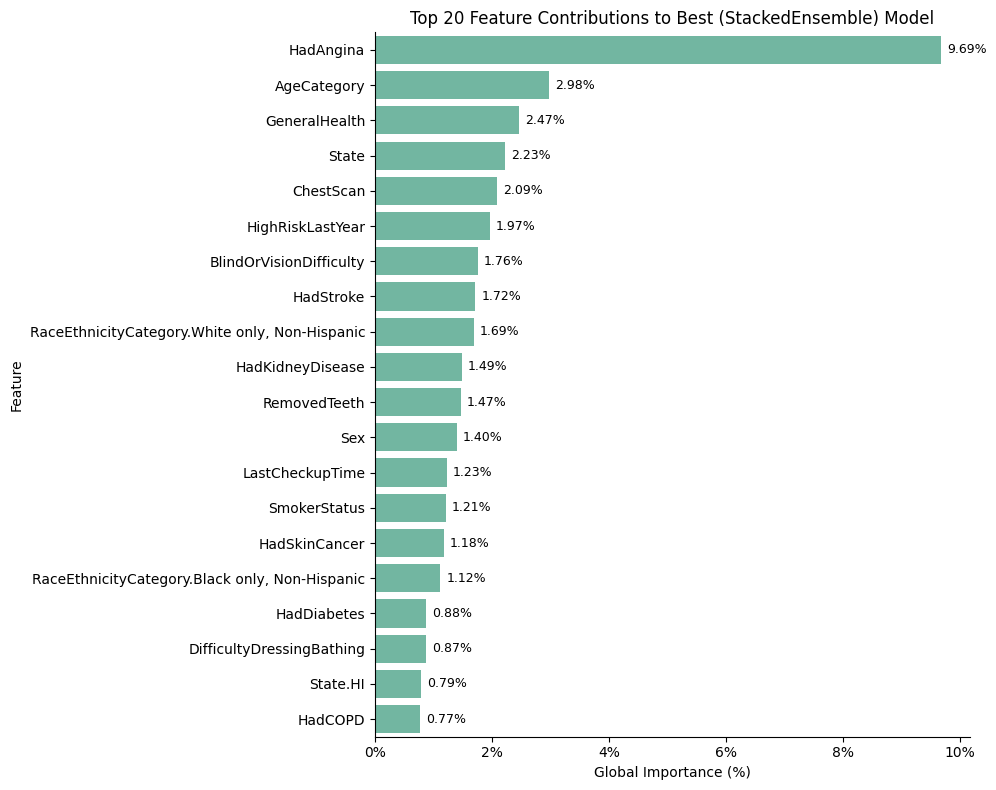

In [49]:
# Plot
top_k = 20
top_features_df = global_importance_df.sort_values(by="global_percentage", ascending=False).head(top_k)

plt.figure(figsize=(10, 8))
ax = sns.barplot(data=top_features_df, x="global_percentage", y="feature", color = green_color)

# Add value annotations
for i, (value, feature) in enumerate(zip(top_features_df["global_percentage"], top_features_df["feature"])):
    ax.text(value + 0.001, i, f"{value*100:.2f}%", va='center', fontsize=9)

plt.xlabel("Global Importance (%)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.ylabel("Feature")
plt.title("Top 20 Feature Contributions to Best (StackedEnsemble) Model")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [50]:
# Save model
model_path = h2o.save_model(model=best_model, path="../models", force=True)

print(f"Model saved to: {model_path}")

Model saved to: /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/models/StackedEnsemble_AllModels_4_AutoML_1_20250529_175705


### Combining SMOTENC Technique

In [ ]:
# Apply SMOTENC
train_pd = train.as_data_frame()

X_train = train_pd.drop(columns=[target])
y_train = train_pd[target]

categorical_cols = ['State', 'RaceEthnicityCategory']
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]


smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_sm, y_train_sm = smote_nc.fit_resample(X_train, y_train)

H2OServerError: HTTP 500 Server Error:
{"__meta":{"schema_version":3,"schema_name":"H2OErrorV3","schema_type":"H2OError"},"timestamp":1748504122616,"error_url":"/3/DownloadDataset","msg":"\n\nERROR MESSAGE:\n\nCaught exception: java.lang.NullPointerException\n\n","dev_msg":"\n\nERROR MESSAGE:\n\nCaught exception: java.lang.NullPointerException from: water.api.DatasetServlet.doGet(DatasetServlet.java:34)\n\n","http_status":500,"values":{},"exception_type":"java.lang.NullPointerException","exception_msg":"\n\nERROR MESSAGE:\n\nnull\n\n","stacktrace":["java.lang.NullPointerException","    water.api.DatasetServlet.doGet(DatasetServlet.java:34)","    javax.servlet.http.HttpServlet.service(HttpServlet.java:687)","    javax.servlet.http.HttpServlet.service(HttpServlet.java:790)","    org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:799)","    org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:554)","    org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:233)","    org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1440)","    org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:188)","    org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:505)","    org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:186)","    org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1355)","    org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:141)","    org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:146)","    org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:127)","    water.webserver.jetty9.Jetty9ServerAdapter$LoginHandler.handle(Jetty9ServerAdapter.java:130)","    org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:146)","    org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:127)","    org.eclipse.jetty.server.Server.handle(Server.java:516)","    org.eclipse.jetty.server.HttpChannel.lambda$handle$1(HttpChannel.java:487)","    org.eclipse.jetty.server.HttpChannel.dispatch(HttpChannel.java:732)","    org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:479)","    org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:277)","    org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:311)","    org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:105)","    org.eclipse.jetty.io.ChannelEndPoint$1.run(ChannelEndPoint.java:104)","    org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:883)","    org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:1034)","    java.base/java.lang.Thread.run(Thread.java:829)"]}

In [ ]:
train_smote_df = pd.concat([X_train_rw_sm, y_train_rw_sm], axis=1)
train_smote_df.to_csv("../data/processed/heart_2022_smote_03.csv", index=False)
test = h2o.import_file("../data/processed/test_data_03.csv",)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
h2o.shutdown(prompt=False)
h2o.init(max_mem_size="8G")

train_smote = h2o.import_file("../data/processed/heart_2022_smote_03.csv")
train_smote[target] = train_smote[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321.

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_40286/2382348473.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       Asia/Taipei
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    2 months and 1 day
H2O_cluster_name:           H2O_from_python_chiushihchan_46iywy
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    8 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.13.3 final
--------------------------  -----------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
features = [col for col in train_smote.columns if col != target]

In [27]:
aml = H2OAutoML(max_runtime_secs = 600, seed=42, balance_classes=True,
    class_sampling_factors=[0.4, 0.6],  # class 0, class 1
    sort_metric="AUTO")
aml.train(x=features, y=target, training_frame=train_smote, leaderboard_frame=test)

AutoML progress: |
14:46:14.967: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20250529_144613


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  --------
Stacking strategy                          blending
Number of base models (used / total)       4/14
# GBM base models (used / total)           4/8
# DRF base models (used / total)           0/2
# GLM base models (used / total)           0/1
# DeepLearning base models (used / total)  0/3
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         AUTO
Metalearner nfolds                         0
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.013839255831272637
RMSE: 0.11764036650432809
LogLoss: 0.0547269756345883
AUC: 0.9982009348793851
AUCPR: 0.9983854809520705
Gini: 0.9964018697587702
Null degrees of freedom: 9859
Residual degrees of freedom: 9855
Null deviance: 13669.091988328895
Residual deviance: 1079.2159595140813
AIC: 1089.2159595140813

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5318350526610289
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      4904  64    0.0129   (64.0/4968.0)
1      90    4802  0.0184   (90.0/4892.0)
Total  4994  4866  0.0156   (154.0/9860.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531835     0.984218  185
max f2                       0.331474     0.985907  226
max f0point5                 0.643923     0.987465  160
max accuracy                 0.531835     0.984381  185
max precision                0.999914     1         0
max recall                   0.00226499   1         392
max specificity              0.999914     1         0
max absolute_mcc             0.531835     0.968773  185
max min_per_class_accuracy   0.473115     0.983034  195
max mean_per_class_accuracy  0.531835     0.98436   185
max tns                      0.999914     4968      0
max fns                      0.999914     4630      0
max fps                      0.000258038  4968      399
max tps                      0.00226499   4892      392
max tnr                      0.999914     1         0
max fnr                      0.999914     0.946443  0
max fpr                      0.000258038  1         399
max tpr                      0.00226499   1         392

Gains/Lift Table: Avg response rate: 49.61 %, avg score: 49.83 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100406                   0.999924           2.01554     2.01554            1                0.999955     1                           0.999955            0.0202371       0.0202371                  101.554   101.554            0.0202371
2        0.0200811                   0.999881           2.01554     2.01554            1                0.999902     1                           0.999929            0.0202371       0.0404742                  101.554   101.554            0.0404742
3        0.0300203                   0.999839           2.01554     2.01554            1                0.999859     1                           0.999906            0.0200327       0.060507                   101.554   101.554            0.060507
4        0.0400609                   0.999797           2.0155

In [28]:
leaderboard = aml.leaderboard.as_data_frame()
model_ids = leaderboard['model_id'].tolist()[:10]
leaderboard

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


model_id       auc   logloss  \
0   StackedEnsemble_AllModels_3_AutoML_1_20250529_...  0.992671  0.102413   
1   StackedEnsemble_BestOfFamily_4_AutoML_1_202505...  0.991746  0.112196   
2         GBM_grid_1_AutoML_1_20250529_144613_model_3  0.991744  0.113983   
3   StackedEnsemble_AllModels_1_AutoML_1_20250529_...  0.991617  0.107084   
4   StackedEnsemble_AllModels_2_AutoML_1_20250529_...  0.991617  0.107084   
5   StackedEnsemble_BestOfFamily_3_AutoML_1_202505...  0.991244  0.111200   
6   StackedEnsemble_BestOfFamily_1_AutoML_1_202505...  0.991244  0.111200   
7   StackedEnsemble_BestOfFamily_2_AutoML_1_202505...  0.991244  0.111200   
8                      GBM_1_AutoML_1_20250529_144613  0.991241  0.111170   
9                      GBM_4_AutoML_1_20250529_144613  0.990481  0.113798   
10                     GBM_3_AutoML_1_20250529_144613  0.989866  0.120821   
11                     GBM_2_AutoML_1_20250529_144613  0.989394  0.124458   
12                     GBM_5_AutoML_1_20250529_144613  0.988685  0.128407   
13        GBM_grid_1_AutoML_1_20250529_144613_model_2  0.986613  0.153381   
14        GBM_grid_1_AutoML_1_20250529_144613_model_1  0.984148  0.171877   
15                     DRF_1_AutoML_1_20250529_144613  0.965354  0.279408   
16                     XRT_1_AutoML_1_20250529_144613  0.950321  0.367662   
17                     GLM_1_AutoML_1_20250529_144613  0.921376  0.358542   
18  DeepLearning_grid_1_AutoML_1_20250529_144613_m...  0.919006  0.689157   
19            DeepLearning_1_AutoML_1_20250529_144613  0.904326  0.675894   
20  DeepLearning_grid_2_AutoML_1_20250529_144613_m...  0.883189  2.177967   
21  DeepLearning_grid_1_AutoML_1_20250529_144613_m...  0.866015  0.696098   
22  DeepLearning_grid_3_AutoML_1_20250529_144613_m...  0.858245  1.255260   

       aucpr  mean_per_class_error      rmse       mse  
0   0.993850              0.035980  0.168366  0.028347  
1   0.992782              0.039437  0.176179  0.031039  
2   0.992781              0.039374  0.178894  0.032003  
3   0.993142              0.037883  0.172428  0.029731  
4   0.993142              0.037883  0.172428  0.029731  
5   0.992732              0.039342  0.175883  0.030935  
6   0.992732              0.039342  0.175883  0.030935  
7   0.992732              0.039342  0.175883  0.030935  
8   0.992732              0.039342  0.176054  0.030995  
9   0.992309              0.039881  0.177026  0.031338  
10  0.991812              0.042196  0.182526  0.033316  
11  0.991461              0.043306  0.185179  0.034291  
12  0.990718              0.045209  0.188144  0.035398  
13  0.988670              0.053709  0.205130  0.042078  
14  0.986802              0.058815  0.216907  0.047049  
15  0.963226              0.097048  0.283121  0.080158  
16  0.949587              0.125021  0.330571  0.109277  
17  0.920116              0.156514  0.333654  0.111325  
18  0.914196              0.158227  0.447180  0.199970  
19  0.899869              0.171674  0.467089  0.218172  
20  0.894458              0.212778  0.649347  0.421652  
21  0.860693              0.218723  0.465819  0.216988  
22  0.847116              0.222799  0.615242  0.378523

In [29]:
validation_revenue_records = []

for model_id in model_ids[:10]:
    model = h2o.get_model(model_id)
    preds = model.predict(train_smote)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = train_smote_df[target].values.flatten()

    threshold, revenue = optimize_revenue_threshold(y_true, y_probs)

    validation_revenue_records.append({
        "model_id": model_id,
        "threshold": threshold,
        "validation_revenue": revenue,
        "source": "SMOTENC"
    })
    
test = h2o.import_file(
    path="../data/processed/test_data_03.csv", 
    destination_frame="test_data_03.hex"
)
test[target] = test[target].asfactor()

test_results = []
for record in validation_revenue_records:
    model = h2o.get_model(record["model_id"])
    preds = model.predict(test)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = test[target].as_data_frame().values.flatten()
    y_pred = (y_probs >= record["threshold"]).astype(int)

    revenue = total_revenue(y_true, y_pred)

    test_results.append({
        "model_id": record["model_id"],
        "threshold": record["threshold"],
        "test_revenue": revenue,
        "validation_revenue": record["validation_revenue"],
        "source": record["source"]
    })


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [30]:
smote_df = pd.DataFrame(test_results)
smote_df["gain_vs_baseline"] = smote_df["test_revenue"] - baseline_revenue
combined_results = pd.concat([results_df.assign(source="original"), smote_df], ignore_index=True)
sorted_combined = combined_results.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)
sorted_combined

model_id  threshold  \
0         GBM_grid_1_AutoML_1_20250529_144613_model_3   0.585859   
1   StackedEnsemble_BestOfFamily_4_AutoML_1_202505...   0.525253   
2   StackedEnsemble_AllModels_3_AutoML_1_20250529_...   0.444444   
3                      GBM_4_AutoML_1_20250529_144613   0.464646   
4   StackedEnsemble_AllModels_2_AutoML_1_20250529_...   0.444444   
5   StackedEnsemble_AllModels_1_AutoML_1_20250529_...   0.444444   
6   StackedEnsemble_BestOfFamily_2_AutoML_1_202505...   0.494949   
7   StackedEnsemble_BestOfFamily_1_AutoML_1_202505...   0.494949   
8   StackedEnsemble_BestOfFamily_3_AutoML_1_202505...   0.494949   
9                      GBM_1_AutoML_1_20250529_144613   0.505051   
10                     GLM_1_AutoML_1_20250529_142848   0.383838   
11  StackedEnsemble_BestOfFamily_3_AutoML_1_202505...   0.393939   
12  StackedEnsemble_AllModels_2_AutoML_1_20250529_...   0.414141   
13  StackedEnsemble_AllModels_1_AutoML_1_20250529_...   0.393939   
14       GBM_grid_1_AutoML_1_20250529_142848_model_47   0.383838   
15  StackedEnsemble_BestOfFamily_1_AutoML_1_202505...   0.404040   
16  StackedEnsemble_BestOfFamily_2_AutoML_1_202505...   0.393939   
17  StackedEnsemble_BestOfFamily_4_AutoML_1_202505...   0.404040   
18  StackedEnsemble_AllModels_4_AutoML_1_20250529_...   0.414141   
19  StackedEnsemble_AllModels_3_AutoML_1_20250529_...   0.414141   

    test_revenue  validation_revenue  gain_vs_baseline    source  
0    19196293674         79720740524        -230577238   SMOTENC  
1    19198651997         79717063559        -228218915   SMOTENC  
2    19262065388         80528483223        -164805524   SMOTENC  
3    19297884995         79105555238        -128985917   SMOTENC  
4    19310136974         79759008134        -116733938   SMOTENC  
5    19310136974         79759008134        -116733938   SMOTENC  
6    19333967933         79571898786         -92902979   SMOTENC  
7    19333967933         79571898786         -92902979   SMOTENC  
8    19333967933         79571898786         -92902979   SMOTENC  
9    19334098626         79573084776         -92772286   SMOTENC  
10   19637750882         78754913699         210879970  original  
11   19649374751         79272297719         222503839  original  
12   19650215468         79381422372         223344556  original  
13   19651461935         79367463618         224591023  original  
14   19652318268         78935312857         225447356  original  
15   19653192148         78971031002         226321236  original  
16   19654013373         79287701918         227142461  original  
17   19656543346         79178138310         229672434  original  
18   19662836116         79359912669         235965204  original  
19   19664152799         79375061345         237281887  original

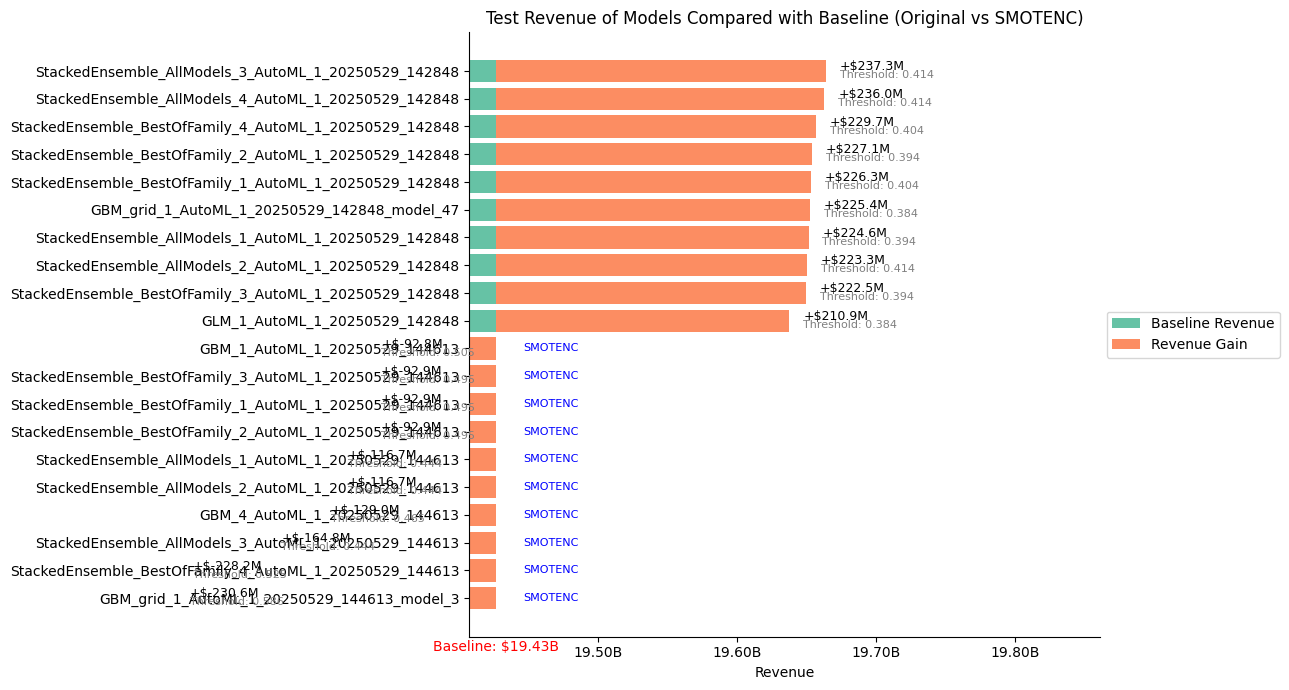

In [31]:
palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]

fig, ax = plt.subplots(figsize=(13, 7))
for i, row in sorted_combined.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    source = row["source"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain" if i == 0 else "")
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

    # Mark SMOTENC models
    if source == "SMOTENC":
        ax.text(baseline_revenue * 1.001, y_pos, "SMOTENC", va='center', fontsize=8, color='blue')

ax.set_yticks(range(len(sorted_combined)))
ax.set_yticklabels(sorted_combined["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compared with Baseline (Original vs SMOTENC)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_combined["test_revenue"].max() * 1.01)
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


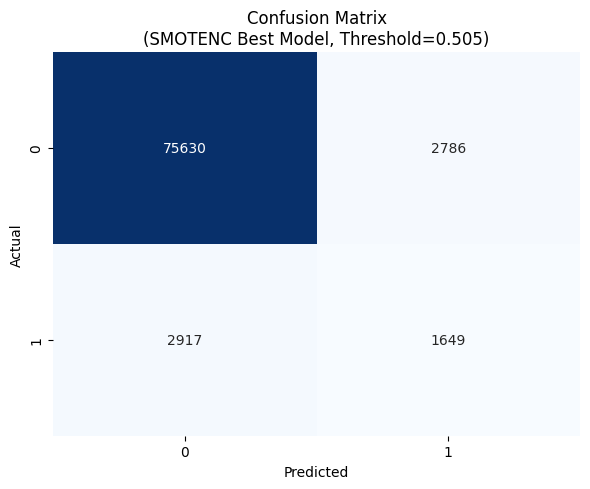

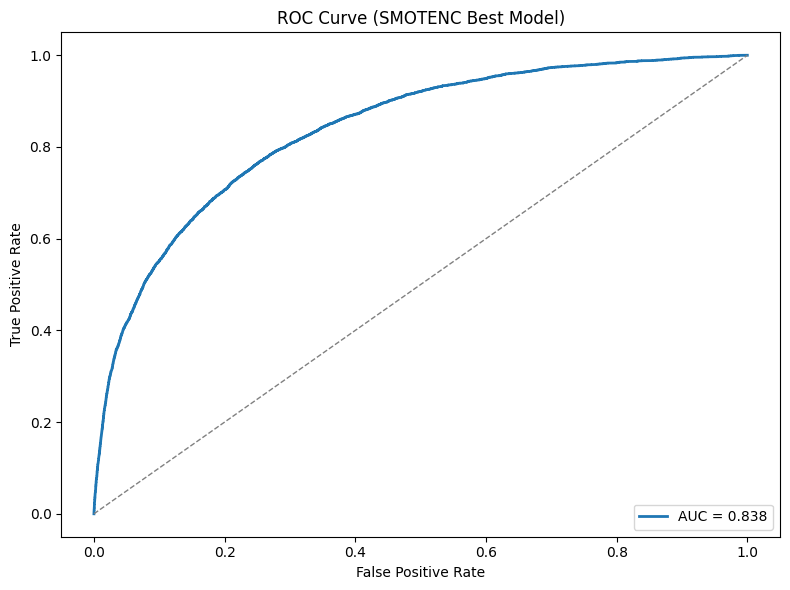

In [32]:
# ========== BEST SMOTENC MODEL EVAL ==========
best_model_row = smote_df.sort_values(by="test_revenue", ascending=False).iloc[0]
best_model_id = best_model_row["model_id"]
best_threshold = best_model_row["threshold"]

best_model = h2o.get_model(best_model_id)
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix\n(SMOTENC Best Model, Threshold={best_threshold:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve (SMOTENC Best Model)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### XGBoost & Lightgbm

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm as lgb
import numpy as np

# Load pre-exported data
train_df = pd.read_csv("../data/processed/train_data_03.csv")
test_df = pd.read_csv("../data/processed/test_data_03.csv")

# Set correct categorical dtypes BEFORE splitting X/y
categorical_cols = ['State', 'RaceEthnicityCategory']
for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

# Target column
target = "HadHeartAttack"

# Split X and y
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Revenue-based custom metric
def total_revenue_score(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return sum(
        271_139 if (yp == 0 and yt == 0) else
       -401_832 if (yp == 0 and yt == 1) else
        0
        for yt, yp in zip(y_true, y_pred)
    )

# Hyperopt search space
space_lgb = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1
}

def objective_lgb(params):
    # Convert float params to int where necessary
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])

    clf = lgb.LGBMClassifier(**params, n_estimators=100)
    clf.fit(X_train, y_train, categorical_feature=categorical_cols)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    revenue = total_revenue_score(y_test.values, y_pred_prob)
    return {'loss': -revenue, 'status': STATUS_OK}

categorical_cols = ['State', 'RaceEthnicityCategory']

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

# Run optimization
trials = Trials()
best_params = fmin(fn=objective_lgb, space=space_lgb, algo=tpe.suggest, max_evals=100, trials=trials)

# Convert necessary float hyperparameters to int before using them
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

# Train final model
final_model = lgb.LGBMClassifier(**best_params, n_estimators=100)
final_model.fit(X_train, y_train, categorical_feature=categorical_cols)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

# Find best threshold
best_threshold = max(np.linspace(0.1, 0.9, 81), key=lambda t: total_revenue_score(y_test, y_pred_prob, t))
y_pred = (y_pred_prob >= best_threshold).astype(int)

100%|██████████| 100/100 [04:23<00:00,  2.64s/trial, best loss: -19641094230.0]


In [54]:
revenue = total_revenue_score(y_test, y_pred_prob, best_threshold)
revenue

19660432932

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_52773/1869510394.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_results_df = pd.concat([results_df, pd.DataFrame([lightgbm_record])], ignore_index=True)


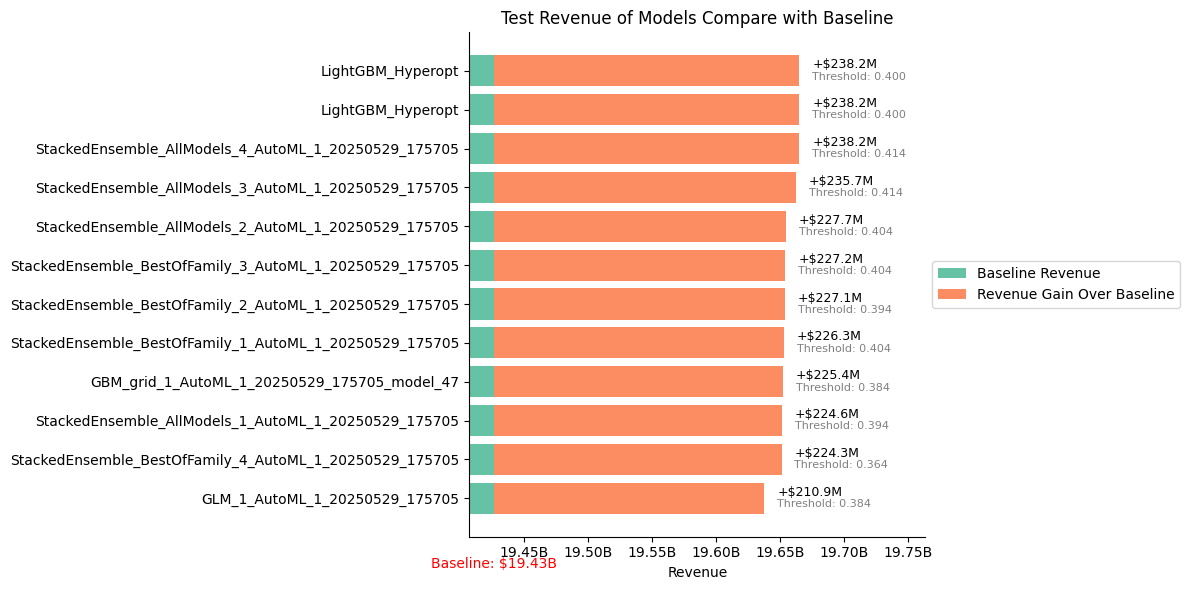

In [67]:
# Load original leaderboard
results_df = pd.read_csv("../data/processed/test_leaderboard_03.csv")

# Add LightGBM Hyperopt result
lightgbm_record = {
    "model_id": "LightGBM_Hyperopt",
    "threshold": best_threshold,
    "test_revenue": revenue,
    "validation_revenue": None,
    "source": "LightGBM_Hyperopt"
}

# Append and calculate gain vs baseline
updated_results_df = pd.concat([results_df, pd.DataFrame([lightgbm_record])], ignore_index=True)
updated_results_df["gain_vs_baseline"] = updated_results_df["test_revenue"] - baseline_revenue

# Sort for plotting
sorted_filtered_df = updated_results_df.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)
sorted_filtered_df.to_csv("../data/processed/test_leaderboard_03.csv")


palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in sorted_filtered_df.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain Over Baseline" if i == 0 else "")
    
    # Annotate gain
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    
    # Annotate threshold
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

# Axis formatting
ax.set_yticks(range(len(sorted_filtered_df)))
ax.set_yticklabels(sorted_filtered_df["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compare with Baseline")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_filtered_df["test_revenue"].max() * 1.005)

# Move baseline annotation slightly downward to avoid overlap
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')

# Clean up the plot
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [60]:
# Evaluation metrics
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.9621170473287021,
  'recall': 0.9819934707202612,
  'f1-score': 0.9719536515790271,
  'support': 78416.0},
 '1': {'precision': 0.5207060420909708,
  'recall': 0.33596145422689444,
  'f1-score': 0.4084132055378062,
  'support': 4566.0},
 'accuracy': 0.9464462172519341,
 'macro avg': {'precision': 0.7414115447098364,
  'recall': 0.6589774624735778,
  'f1-score': 0.6901834285584166,
  'support': 82982.0},
 'weighted avg': {'precision': 0.9378288565172552,
  'recall': 0.9464462172519341,
  'f1-score': 0.9409454127245261,
  'support': 82982.0}}

In [61]:
cm = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

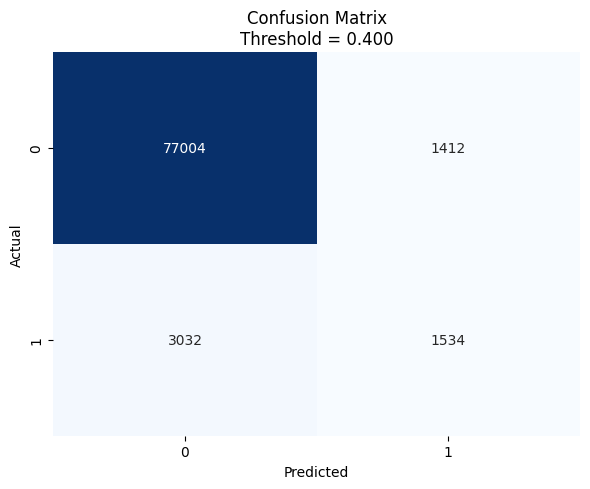

In [62]:
# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix\nThreshold = {best_threshold:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

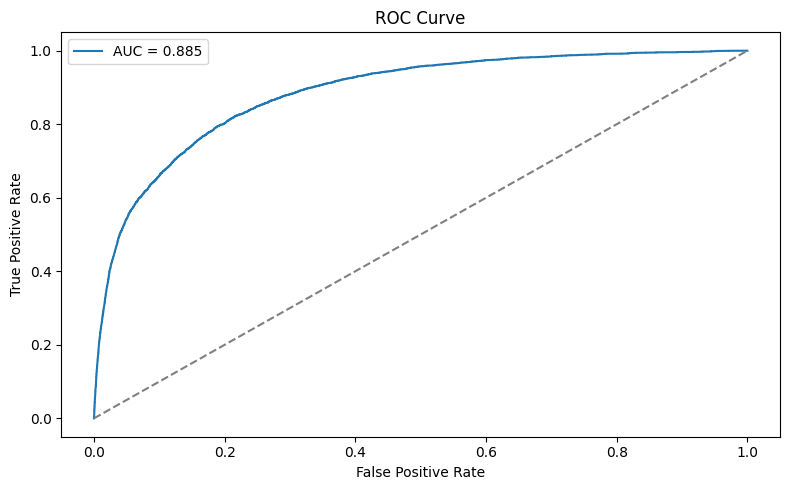

In [63]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Format metric results
metrics_df = pd.DataFrame.from_dict(report).T
metrics_df["AUC"] = auc_score
metrics_df["Revenue"] = revenue

In [65]:
# Save model to a file
final_model.booster_.save_model("../models/lightgbm_hyperopt_model.txt")

In [69]:
import xgboost as xgb

# Hyperopt search space for XGBoost
# Enable categorical handling
xgb_kwargs = {
    "enable_categorical": True,
    "use_label_encoder": False,
    "objective": "binary:logistic",
    "eval_metric": "logloss"
}
space_xgb = {
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

# Objective function for Hyperopt
def objective_xgb(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    clf = xgb.XGBClassifier(**xgb_kwargs, **params, n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    revenue = total_revenue_score(y_test.values, y_pred_prob)
    return {'loss': -revenue, 'status': STATUS_OK}

# Run optimization
trials = Trials()
best_params_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=100, trials=trials)

# Final model training
best_params_xgb['max_depth'] = int(best_params_xgb['max_depth'])
best_params_xgb['min_child_weight'] = int(best_params_xgb['min_child_weight'])
final_xgb_model = xgb.XGBClassifier(**xgb_kwargs, **best_params_xgb, n_estimators=100)
final_xgb_model.fit(X_train, y_train)
y_pred_prob_xgb = final_xgb_model.predict_proba(X_test)[:, 1]

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  1%|          | 1/100 [00:02<04:15,  2.58s/trial, best loss: -19520033528.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 2/100 [00:05<04:51,  2.98s/trial, best loss: -19520033528.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  3%|▎         | 3/100 [00:07<03:44,  2.31s/trial, best loss: -19614924440.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 4/100 [00:09<03:34,  2.24s/trial, best loss: -19614924440.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 5/100 [00:12<03:43,  2.36s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 6/100 [00:14<03:43,  2.38s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|▋         | 7/100 [00:16<03:32,  2.29s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 8/100 [00:19<03:40,  2.40s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  9%|▉         | 9/100 [00:23<04:39,  3.07s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 10/100 [00:25<03:50,  2.56s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 11%|█         | 11/100 [00:27<03:36,  2.43s/trial, best loss: -19631155713.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 12/100 [00:28<03:11,  2.18s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 13/100 [00:30<02:52,  1.99s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 14/100 [00:32<02:39,  1.86s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 15/100 [00:36<03:43,  2.63s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 16/100 [00:38<03:31,  2.52s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|█▋        | 17/100 [00:40<03:07,  2.26s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 18/100 [00:44<03:48,  2.79s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 19%|█▉        | 19/100 [00:46<03:42,  2.74s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 20/100 [00:50<03:59,  2.99s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 21%|██        | 21/100 [00:53<04:06,  3.12s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 22/100 [00:56<03:41,  2.84s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██▎       | 23/100 [00:59<04:01,  3.13s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 24/100 [01:02<03:51,  3.04s/trial, best loss: -19633332633.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 25/100 [01:04<03:26,  2.75s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 26/100 [01:07<03:09,  2.56s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 27/100 [01:09<02:57,  2.43s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 28/100 [01:10<02:37,  2.19s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 29%|██▉       | 29/100 [01:12<02:33,  2.16s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 30/100 [01:14<02:29,  2.14s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 31%|███       | 31/100 [01:16<02:14,  1.95s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 32/100 [01:19<02:30,  2.21s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███▎      | 33/100 [01:21<02:36,  2.33s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 34/100 [01:24<02:37,  2.38s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 35/100 [01:28<02:59,  2.76s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 36/100 [01:33<03:46,  3.55s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 37/100 [01:36<03:40,  3.49s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 38/100 [01:38<03:00,  2.91s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 39%|███▉      | 39/100 [01:41<02:56,  2.89s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 40/100 [01:43<02:41,  2.69s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 41%|████      | 41/100 [01:45<02:22,  2.41s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 42/100 [01:46<02:07,  2.20s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|████▎     | 43/100 [01:48<01:55,  2.03s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 44/100 [01:50<01:47,  1.91s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 45/100 [01:52<01:44,  1.91s/trial, best loss: -19634920455.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 46/100 [01:54<01:44,  1.93s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 47/100 [01:56<01:50,  2.09s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 48/100 [01:58<01:43,  1.99s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 49%|████▉     | 49/100 [02:00<01:52,  2.21s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 50/100 [02:03<02:02,  2.46s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 51%|█████     | 51/100 [02:06<02:00,  2.46s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 52/100 [02:08<01:51,  2.32s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 53/100 [02:10<01:48,  2.30s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 54/100 [02:12<01:41,  2.20s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 55/100 [02:16<02:03,  2.76s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████▌    | 56/100 [02:18<01:53,  2.58s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 57/100 [02:21<01:44,  2.44s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 58/100 [02:23<01:46,  2.54s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 59%|█████▉    | 59/100 [02:27<02:00,  2.95s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 60/100 [02:31<02:12,  3.31s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 61%|██████    | 61/100 [02:35<02:10,  3.35s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 62%|██████▏   | 62/100 [02:38<02:06,  3.33s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|██████▎   | 63/100 [02:42<02:06,  3.41s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 64/100 [02:45<02:02,  3.39s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 65/100 [02:49<02:00,  3.45s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 66/100 [02:51<01:49,  3.22s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 67%|██████▋   | 67/100 [02:54<01:40,  3.06s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 68/100 [02:57<01:36,  3.01s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 69%|██████▉   | 69/100 [03:00<01:34,  3.05s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 70/100 [03:03<01:31,  3.06s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 71%|███████   | 71/100 [03:06<01:25,  2.95s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|███████▏  | 72/100 [03:09<01:21,  2.92s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 73/100 [03:11<01:14,  2.76s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|███████▍  | 74/100 [03:13<01:05,  2.52s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 75/100 [03:15<00:56,  2.24s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 76/100 [03:17<00:52,  2.20s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 77/100 [03:20<00:56,  2.46s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████▊  | 78/100 [03:22<00:53,  2.43s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 79%|███████▉  | 79/100 [03:27<01:05,  3.12s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 80/100 [03:29<00:55,  2.78s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 81%|████████  | 81/100 [03:31<00:51,  2.73s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 82%|████████▏ | 82/100 [03:34<00:50,  2.79s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|████████▎ | 83/100 [03:36<00:41,  2.46s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 84%|████████▍ | 84/100 [03:39<00:41,  2.56s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 85/100 [03:42<00:41,  2.78s/trial, best loss: -19637044706.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 86/100 [03:44<00:35,  2.53s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 87%|████████▋ | 87/100 [03:46<00:30,  2.38s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 88/100 [03:48<00:27,  2.28s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 89%|████████▉ | 89/100 [03:50<00:23,  2.10s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 90/100 [03:51<00:19,  1.96s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 91%|█████████ | 91/100 [03:53<00:17,  1.95s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 92/100 [03:55<00:15,  1.95s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|█████████▎| 93/100 [03:57<00:13,  1.87s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 94/100 [03:59<00:11,  1.88s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 95/100 [04:01<00:09,  1.84s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 96/100 [04:03<00:07,  1.99s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|█████████▋| 97/100 [04:05<00:06,  2.08s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████▊| 98/100 [04:07<00:04,  2.04s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 99%|█████████▉| 99/100 [04:11<00:02,  2.41s/trial, best loss: -19649255714.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 100/100 [04:13<00:00,  2.53s/trial, best loss: -19649255714.0]


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [18:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# Determine best threshold
best_threshold_xgb = max(np.linspace(0.1, 0.9, 81), key=lambda t: total_revenue_score(y_test, y_pred_prob_xgb, t))
y_pred_xgb = (y_pred_prob_xgb >= best_threshold_xgb).astype(int)
revenue_xgb = total_revenue_score(y_test, y_pred_prob_xgb, best_threshold_xgb)
revenue_xgb

19658425703

In [33]:
# Load original leaderboard
results_df = pd.read_csv("../data/processed/test_leaderboard_03.csv")

# # Add XGBoost result
# xgb_record = {
#     "model_id": "XGBoost_Hyperopt",
#     "threshold": best_threshold_xgb,
#     "test_revenue": revenue_xgb,
#     "validation_revenue": None,
#     "source": "XGBoost_Hyperopt"
# }
# updated_results_df = pd.concat([results_df, pd.DataFrame([xgb_record])], ignore_index=True)
# updated_results_df["gain_vs_baseline"] = updated_results_df["test_revenue"] - baseline_revenue
sorted_filtered_df = results_df.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)

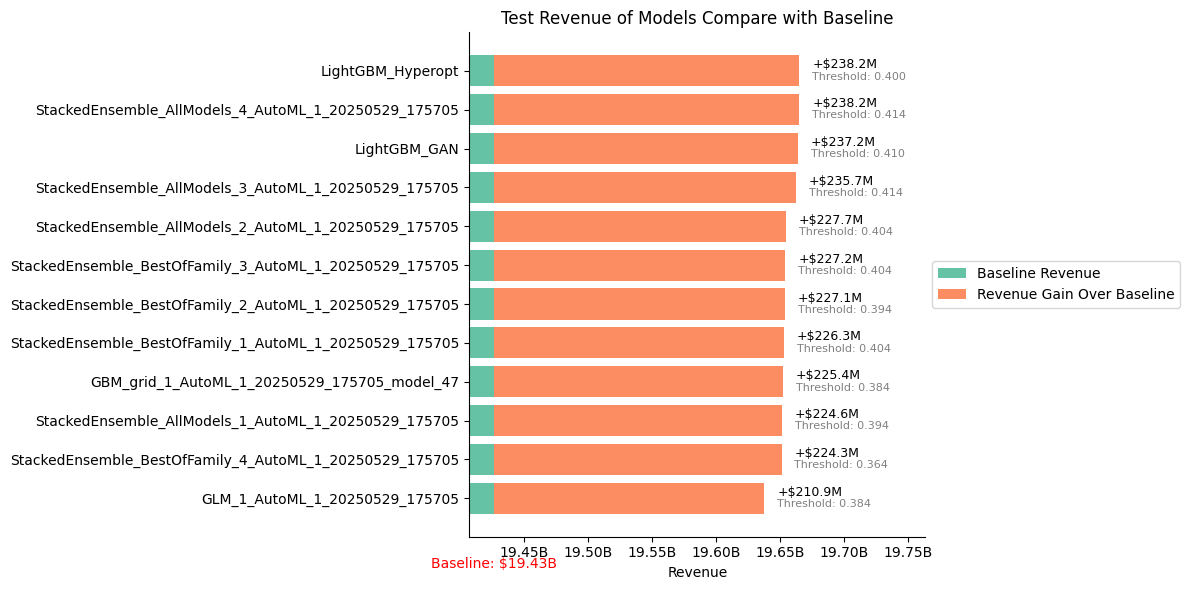

In [ ]:
# Plotting
baseline_revenue = 19426870912
palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]
fig, ax = plt.subplots(figsize=(12, 6))
for i, row in sorted_filtered_df.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    y_pos = i
    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain Over Baseline" if i == 0 else "")
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

ax.set_yticks(range(len(sorted_filtered_df)))
ax.set_yticklabels(sorted_filtered_df["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compare with Baseline")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_filtered_df["test_revenue"].max() * 1.005)
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

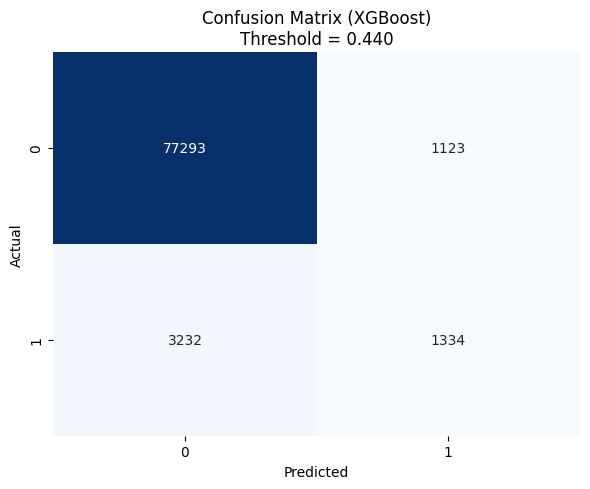

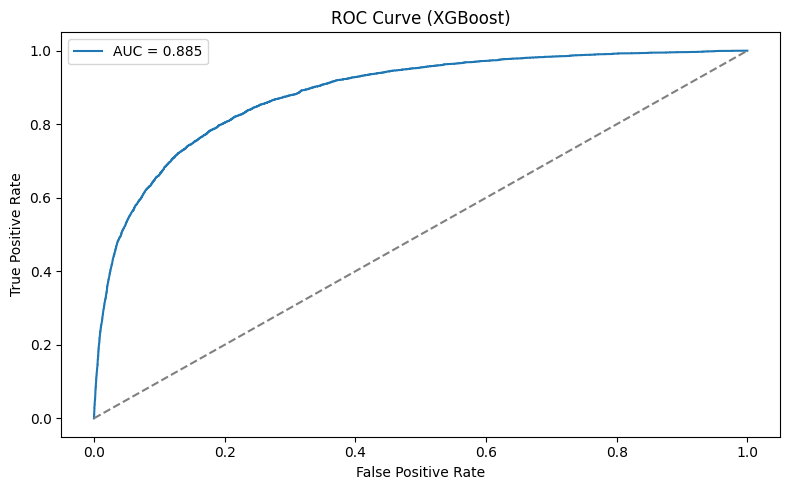

In [78]:
# Evaluation
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix (XGBoost)\nThreshold = {best_threshold_xgb:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC plot
plt.figure(figsize=(8, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {auc_xgb:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
# Save model
final_xgb_model.save_model("../models/xgboost_hyperopt_model.json")

# Format metric results
metrics_df_xgb = pd.DataFrame.from_dict(report_xgb).T
metrics_df_xgb["AUC"] = auc_xgb
metrics_df_xgb["Revenue"] = revenue_xgb

### GANs Models

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# --- 1. Load data ---
train_df = pd.read_csv("../data/processed/train_data_03.csv")
test_df = pd.read_csv("../data/processed/test_data_03.csv")
target_col = "HadHeartAttack"
categorical_cols = ['State', 'RaceEthnicityCategory']

# --- 2. Encode both train and test sets together ---
combined_df = pd.concat([train_df.drop(columns=[target_col]), test_df], axis=0)
encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)],
    remainder='passthrough'
)
combined_encoded = encoder.fit_transform(combined_df)

X_train_encoded = combined_encoded[:len(train_df)]
X_test_encoded = combined_encoded[len(train_df):]
y_train = train_df[target_col]
y_test = test_df[target_col]

# --- 3. Train GAN on positive class only ---
positive_idx = y_train == 1
positive_data = X_train_encoded[positive_idx]
positive_tensor = torch.tensor(positive_data.toarray() if hasattr(positive_data, 'toarray') else positive_data, dtype=torch.float32)

class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def train_gan(data, noise_dim=32, n_epochs=100, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G = Generator(noise_dim, data.shape[1]).to(device)
    D = Discriminator(data.shape[1]).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002)

    dataset = TensorDataset(data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(n_epochs), desc="Training GAN"):
        for batch in loader:
            real = batch[0].to(device)
            b_size = real.size(0)
            z = torch.randn(b_size, noise_dim).to(device)
            fake = G(z)

            # Train Discriminator
            D_real_out = D(real)
            D_fake_out = D(fake.detach())
            loss_D = criterion(D_real_out, torch.ones_like(D_real_out)) + \
                    criterion(D_fake_out, torch.zeros_like(D_fake_out))
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            z = torch.randn(b_size, noise_dim).to(device)
            fake = G(z)
            loss_G = criterion(D(fake), torch.ones_like(D(fake)))
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

    return G

G = train_gan(positive_tensor)

# --- 4. Generate synthetic data to balance ---
n_minority = y_train.sum()
n_majority = len(y_train) - n_minority
n_to_generate = n_majority - n_minority

noise = torch.randn(n_to_generate, 32)
synthetic_data = G(noise).detach().cpu().numpy()
synthetic_y = np.ones(n_to_generate)

# --- 5. Combine real + synthetic ---
X_train_final = np.vstack([X_train_encoded.toarray() if hasattr(X_train_encoded, 'toarray') else X_train_encoded, synthetic_data])
y_train_final = np.concatenate([y_train.values, synthetic_y])

# --- 6. Define LightGBM revenue function ---
def total_revenue_score(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)
    return sum(
        271_139 if (yp == 0 and yt == 0) else
       -401_832 if (yp == 0 and yt == 1) else
        0 for yt, yp in zip(y_true, y_pred)
    )

# --- 7. Define Hyperopt search space ---
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])
    model = lgb.LGBMClassifier(**params, n_estimators=100)
    model.fit(X_train_final, y_train_final)
    y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
    return {'loss': -total_revenue_score(y_test, y_pred_prob), 'status': STATUS_OK}

# --- 8. Run Hyperopt ---
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# --- 9. Train final model and evaluate ---
for k in ['num_leaves', 'max_depth', 'min_child_samples']:
    best_params[k] = int(best_params[k])

final_model = lgb.LGBMClassifier(**best_params, n_estimators=100)
final_model.fit(X_train_final, y_train_final)
y_pred_prob = final_model.predict_proba(X_test_encoded)[:, 1]
best_threshold = max(np.linspace(0.1, 0.9, 81), key=lambda t: total_revenue_score(y_test, y_pred_prob, t))
final_revenue = total_revenue_score(y_test, y_pred_prob, best_threshold)

print(f"Best Threshold: {best_threshold}, Final Revenue: {final_revenue}")

Training GAN: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


  2%|▏         | 1/50 [00:02<02:21,  2.89s/trial, best loss: -19607837773.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



  4%|▍         | 2/50 [00:07<03:02,  3.79s/trial, best loss: -19621355697.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



  6%|▌         | 3/50 [00:10<02:39,  3.39s/trial, best loss: -19625212106.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



  8%|▊         | 4/50 [00:16<03:20,  4.37s/trial, best loss: -19625212106.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 10%|█         | 5/50 [00:19<02:59,  3.99s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 12%|█▏        | 6/50 [00:24<03:10,  4.34s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 14%|█▍        | 7/50 [00:27<02:47,  3.90s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 16%|█▌        | 8/50 [00:30<02:29,  3.57s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 18%|█▊        | 9/50 [00:33<02:22,  3.47s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 20%|██        | 10/50 [00:36<02:13,  3.34s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 22%|██▏       | 11/50 [00:40<02:14,  3.45s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 24%|██▍       | 12/50 [00:46<02:43,  4.30s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 26%|██▌       | 13/50 [00:51<02:46,  4.49s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 28%|██▊       | 14/50 [00:57<03:01,  5.03s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 30%|███       | 15/50 [01:02<02:50,  4.87s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 32%|███▏      | 16/50 [01:05<02:31,  4.45s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 34%|███▍      | 17/50 [01:10<02:26,  4.43s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 36%|███▌      | 18/50 [01:14<02:24,  4.51s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 38%|███▊      | 19/50 [01:18<02:16,  4.39s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 40%|████      | 20/50 [01:22<02:09,  4.30s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 42%|████▏     | 21/50 [01:26<01:59,  4.13s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 44%|████▍     | 22/50 [01:30<01:51,  3.99s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 46%|████▌     | 23/50 [01:33<01:44,  3.87s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 48%|████▊     | 24/50 [01:36<01:33,  3.59s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 50%|█████     | 25/50 [01:40<01:27,  3.50s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 52%|█████▏    | 26/50 [01:43<01:24,  3.53s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 54%|█████▍    | 27/50 [01:48<01:26,  3.78s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 56%|█████▌    | 28/50 [01:52<01:23,  3.80s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 58%|█████▊    | 29/50 [01:55<01:14,  3.57s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 60%|██████    | 30/50 [01:58<01:11,  3.57s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 62%|██████▏   | 31/50 [02:01<01:04,  3.37s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 64%|██████▍   | 32/50 [02:05<01:03,  3.55s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 66%|██████▌   | 33/50 [02:09<01:02,  3.65s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 68%|██████▊   | 34/50 [02:12<00:56,  3.51s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 70%|███████   | 35/50 [02:17<01:00,  4.06s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 72%|███████▏  | 36/50 [02:21<00:54,  3.88s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 74%|███████▍  | 37/50 [02:26<00:53,  4.15s/trial, best loss: -19637922490.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 76%|███████▌  | 38/50 [02:29<00:46,  3.88s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 78%|███████▊  | 39/50 [02:33<00:42,  3.89s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 80%|████████  | 40/50 [02:36<00:37,  3.71s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 82%|████████▏ | 41/50 [02:39<00:31,  3.51s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 84%|████████▍ | 42/50 [02:42<00:27,  3.47s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 86%|████████▌ | 43/50 [02:46<00:24,  3.49s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 88%|████████▊ | 44/50 [02:51<00:23,  3.87s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 90%|█████████ | 45/50 [02:56<00:21,  4.22s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 92%|█████████▏| 46/50 [02:59<00:15,  3.96s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 94%|█████████▍| 47/50 [03:03<00:11,  3.81s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 96%|█████████▌| 48/50 [03:06<00:07,  3.64s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 98%|█████████▊| 49/50 [03:11<00:04,  4.08s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



100%|██████████| 50/50 [03:15<00:00,  3.91s/trial, best loss: -19639268432.0]

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Threshold: 0.41000000000000003, Final Revenue: 19664037708


In [32]:
# 12. Save model and update leaderboard
final_model.booster_.save_model("../models/lightgbm_gan_augmented.txt")

import json
gan_record = {
    "model_id": "LightGBM_GAN",
    "threshold": best_threshold,
    "test_revenue": final_revenue,
    "validation_revenue": None,
    "source": "GAN"
}
results_df = pd.read_csv("../data/processed/test_leaderboard_03.csv")
results_df = pd.concat([results_df, pd.DataFrame([gan_record])], ignore_index=True)
results_df.to_csv("../data/processed/test_leaderboard_03.csv", index=False)

NameError: name 'final_model' is not defined

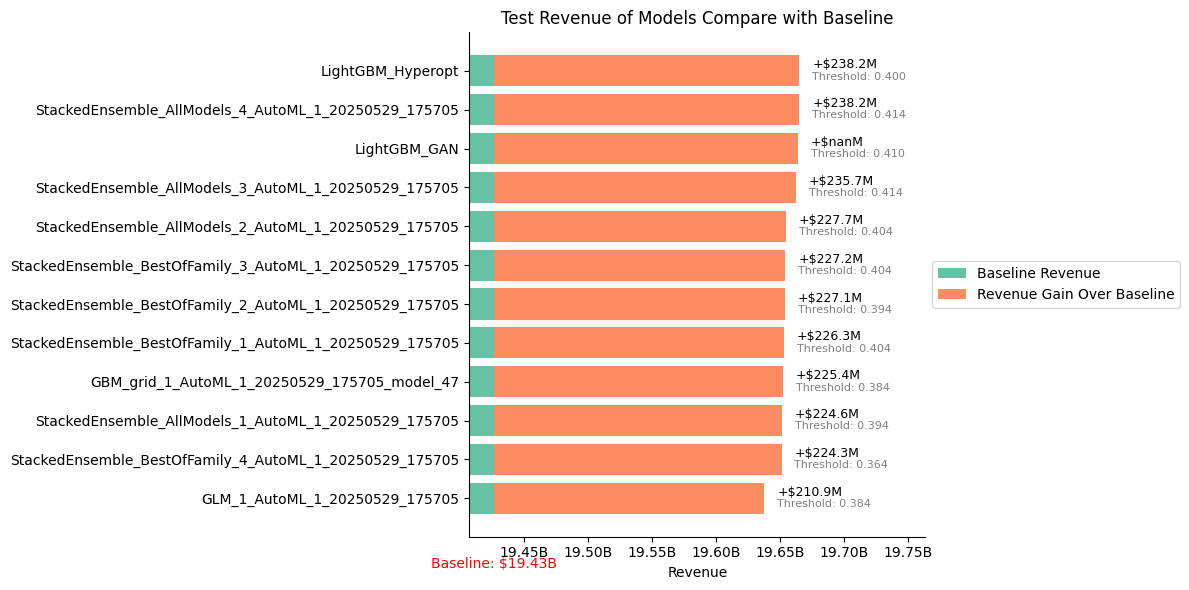

In [28]:
palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]
baseline_revenue = 19426870912
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

sorted_filtered_df = results_df.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)
for i, row in sorted_filtered_df.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain Over Baseline" if i == 0 else "")
    
    # Annotate gain
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    
    # Annotate threshold
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

# Axis formatting
ax.set_yticks(range(len(sorted_filtered_df)))
ax.set_yticklabels(sorted_filtered_df["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compare with Baseline")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_filtered_df["test_revenue"].max() * 1.005)

# Move baseline annotation slightly downward to avoid overlap
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')

# Clean up the plot
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### SHAP

/Users/chiushihchan/miniconda3/envs/shapenv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


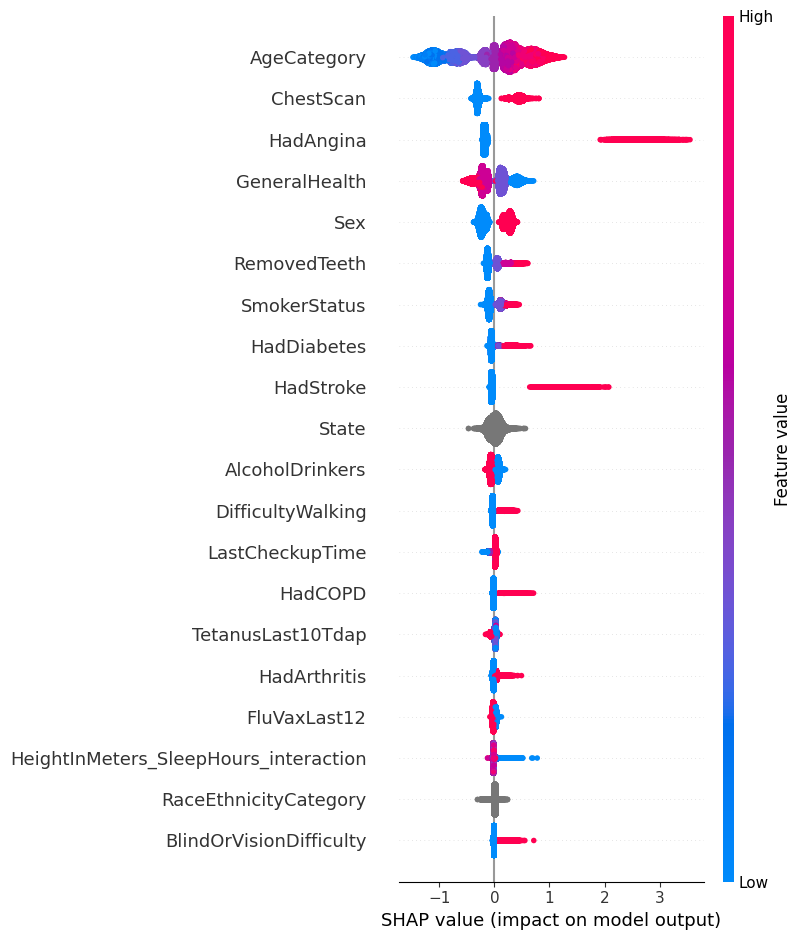

In [16]:
import shap
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load model
model = lgb.Booster(model_file="../models/lightgbm_hyperopt_model.txt")

# 2. Load and prepare test set (do not one-hot encode)
test_df = pd.read_csv("../data/processed/test_data_03.csv")
categorical_cols = ['State', 'RaceEthnicityCategory']
for col in categorical_cols:
    test_df[col] = test_df[col].astype('category')

# 3. Separate features and target
X_test = test_df.drop(columns=["HadHeartAttack"])
y_test = test_df["HadHeartAttack"]

# 4. SHAP Explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 5. Plot SHAP summary
shap.summary_plot(shap_values, X_test, max_display=20)

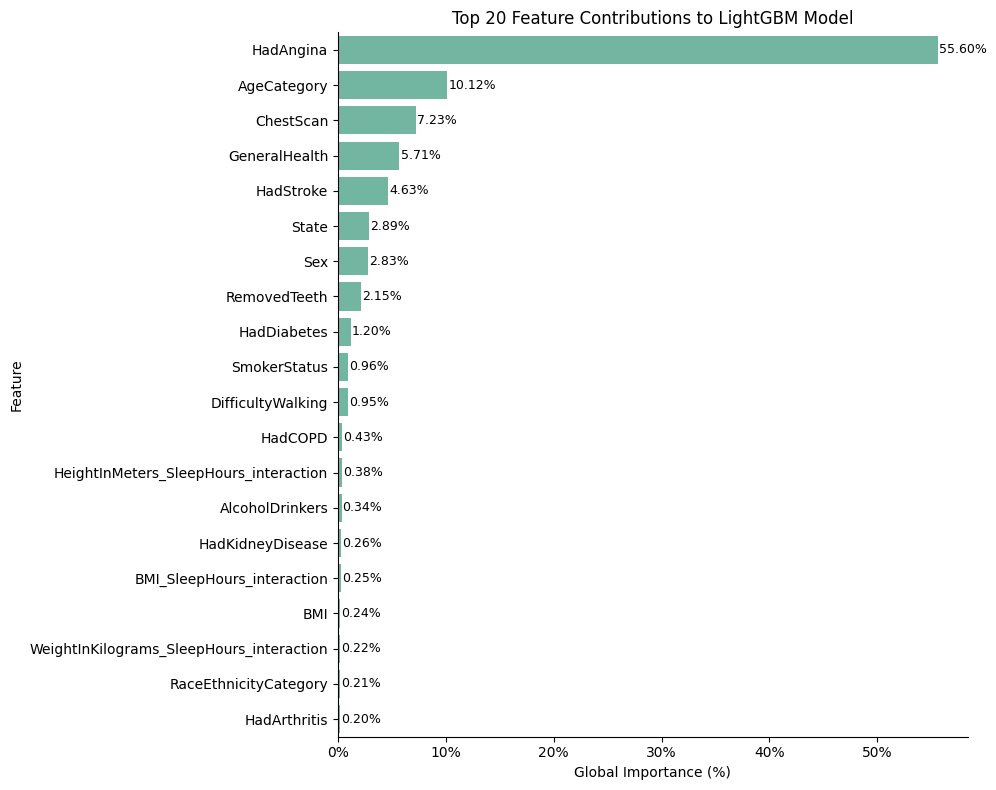

In [ ]:
import seaborn as sns
# Get feature importance by gain (how much a feature contributes to reducing loss)
importance_values = model.feature_importance(importance_type="gain")
feature_names = model.feature_name()

# Create DataFrame
global_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_gain": importance_values
})

# Normalize to percentages
global_importance_df["global_percentage"] = global_importance_df["importance_gain"] / global_importance_df["importance_gain"].sum()

# Plot
palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
top_k = 20
top_features_df = global_importance_df.sort_values(by="global_percentage", ascending=False).head(top_k)

plt.figure(figsize=(10, 8))
ax = sns.barplot(data=top_features_df, x="global_percentage", y="feature", color=green_color)

# Add value annotations
for i, (value, feature) in enumerate(zip(top_features_df["global_percentage"], top_features_df["feature"])):
    ax.text(value + 0.001, i, f"{value*100:.2f}%", va='center', fontsize=9)

plt.xlabel("Global Importance (%)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.ylabel("Feature")
plt.title("Top 20 Feature Contributions to LightGBM Model")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

/Users/chiushihchan/miniconda3/envs/shapenv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


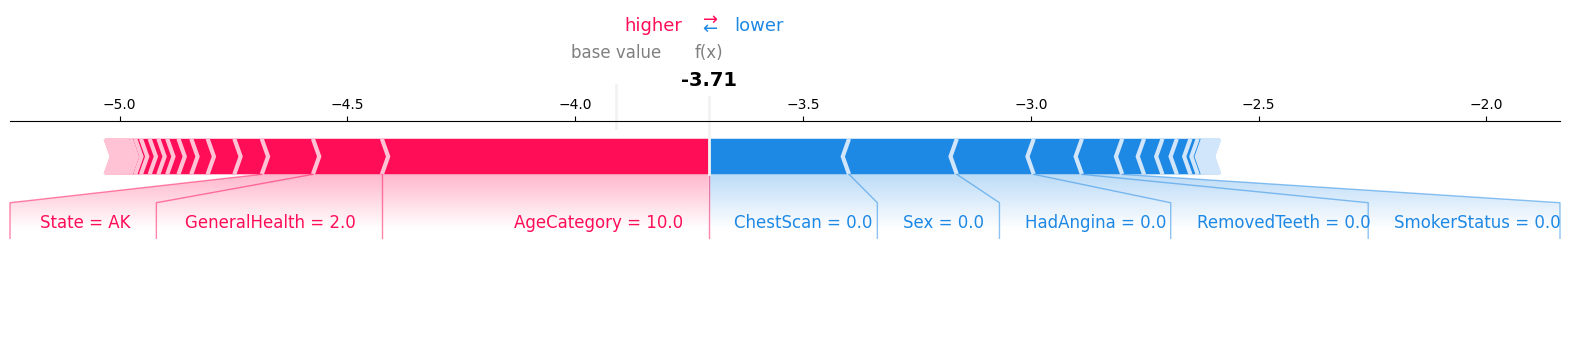

In [3]:
shap.initjs()

shap_values = explainer.shap_values(X_test)

# Pick an index
index = 1000  # You can change this to another row

# Use shap_values directly
shap.force_plot(
    explainer.expected_value,        
    shap_values[index],               
    X_test.iloc[index],               
    matplotlib=True
)


In [4]:
import numpy as np
# For binary classification, scalar expected value + sum of SHAP values ≈ model output (log-odds)
log_odds = explainer.expected_value + shap_values.sum(axis=1)

# Convert log-odds to probability
probs = 1 / (1 + np.exp(-log_odds))
positive_indices = np.where(probs >= 0.5)[0]
positive_indices

array([   62,   377,   434, ..., 82601, 82639, 82953], shape=(1682,))

/Users/chiushihchan/miniconda3/envs/shapenv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


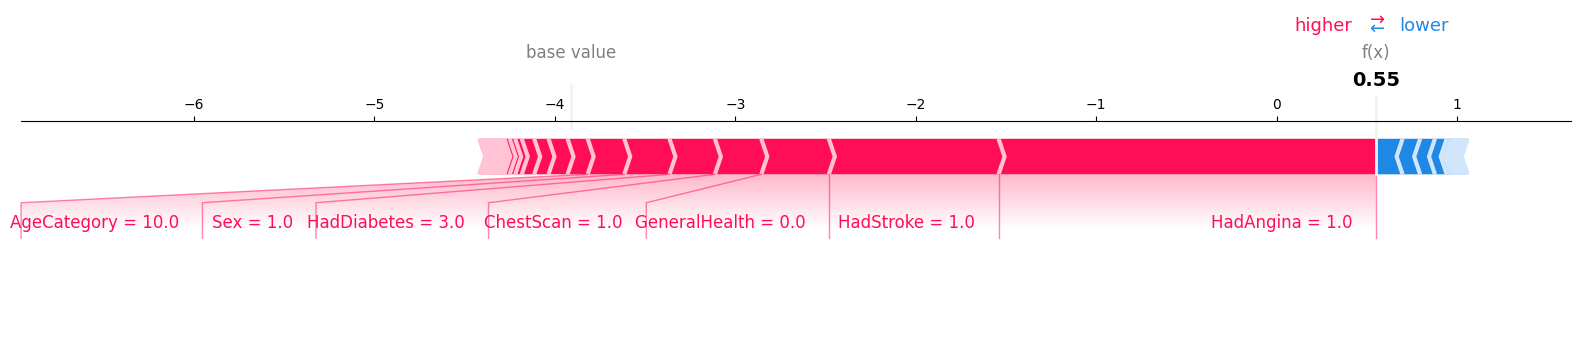

In [5]:
shap.initjs()

shap_values = explainer.shap_values(X_test)

# Pick an index
index = 62  # You can change this to another row

# Use shap_values directly (not indexing with [1])
shap.force_plot(
    explainer.expected_value,        
    shap_values[index],               
    X_test.iloc[index],               
    matplotlib=True
)

In [ ]:
shap.decision_plot(
    explainer.expected_value[predicted_class],
    shap_values[predicted_class][sample_idx, :-1],
    feature_names=feature_names
)

In [10]:
base_values = np.full(X_test.shape[0], explainer.expected_value)
base_values

array([-3.90982874, -3.90982874, -3.90982874, ..., -3.90982874,
       -3.90982874, -3.90982874], shape=(82982,))

In [ ]:
# Create Explanation object for SHAP force plot
explanation = shap.Explanation(
    values=shap_values,                     # shape (n_samples, n_features)
    base_values=base_values,               # shape (n_samples,)
    data=X_test.values,                    # shape (n_samples, n_features)
    feature_names=X_test.columns.tolist()
)
# Save to HTML file (first 500 samples)
shap.save_html("shap_force_plot.html", shap.plots.force(explanation[:500], plot_cmap="DrDb"))
# Plot multiple force plots
shap.plots.force(explanation[:500], plot_cmap="DrDb")